### Setup

In [2]:
from pathlib import Path
import utilities as util

### Load the cloud dataset
Initially shuffle and reshuffle_each_iteration were both set to False. This was not a good choice because when unshuffled, the training data is chosen from the top of the list of files and the validation data is chosen from the bottom. This results in the training data being too different from the validation data to be able to classify the validation data. After setting these parameters to true, validation accuracy went from ~.3 to ~.85.

In [3]:
data_dir = Path('./data/test')
list_ds, image_count = util.load_data(data_dir)

there are 2543 images



### Summary of training/validation data

with 11 different classes
 ['Ac' 'As' 'Cb' 'Cc' 'Ci' 'Cs' 'Ct' 'Cu' 'Ns' 'Sc' 'St'] 



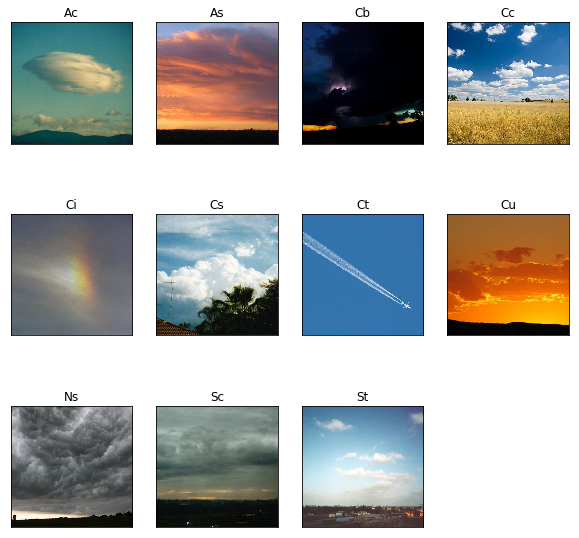

In [4]:
util.get_class_names(data_dir)
util.plot_ex_images(data_dir)


In [5]:
# allocate data for training and for validation
train_ds, val_ds = util.allocate_data(list_ds, image_count)

2035 images are used for training
508 images are used for validation


## optimize algorithm
tf.data builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all tunable operations. While the input pipeline is running, tf.data tracks the time spent in each operation, so that these times can be fed into the optimization algorithm.



In [6]:
# set up parallel processing and performance
train_ds, val_ds = util.configuration(train_ds, val_ds)

## run models 


In [ ]:
num_epochs = 3

model = util.build_base_model()
history = util.fit_model(train_ds, val_ds, model, num_epochs)
util.plot_results(history, num_epochs)


2021-01-13 14:16:36.586 | INFO     | utilities:fit_model:223 - Start training


Epoch 1/3
64/64 [==============================] - 180s 3s/step - loss: 3.5766 - accuracy: 0.1556 - val_loss: 2.2078 - val_accuracy: 0.2500
Epoch 2/3


In [ ]:
model = util.build_base_model_dropout()
history = util.fit_model(train_ds, val_ds, model, num_epochs)
util.plot_results(history, num_epochs)
